# Post Training Analyses

In this notebook we will demonstrate how to perform post training analyses as shown in our [manuscript](https://www.biorxiv.org/content/10.1101/2024.01.30.577989v1).

## Preparation

In [1]:
import pandas as pd
from metmhn.model import MetMHN
from metmhn.state import MetState

# load in mutation and annotation data
mut_handle = "../data/luad/G14_LUAD_Events.csv"
annot_handle = "../data/luad/G14_LUAD_sampleSelection.csv"
log_theta_handle = "../results/luad/luad_g14_cv_20muts_8cnvs.csv"

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/lhu/MetMHN/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let us first load some patient data:

In [2]:
mut_df = pd.read_csv(mut_handle, index_col=0)
mut_df.head()

,P.TP53 (M),M.TP53 (M),P.TERT/5p (Amp),M.TERT/5p (Amp),P.MCL1/1q (Amp),M.MCL1/1q (Amp),P.KRAS (M),M.KRAS (M),P.CDKN2A/9p (Del),M.CDKN2A/9p (Del),...,M.SETD2 (M),P.RB1 (M),M.RB1 (M),P.MET (M),M.MET (M),P.KMT2C (M),M.KMT2C (M),paired,P.AgeAtSeqRep,M.AgeAtSeqRep
GENIE-MSK-P-0000030,0,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,No primary included,68
GENIE-MSK-P-0000036,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,58,No metastasis included
GENIE-MSK-P-0000082,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,60,No metastasis included
GENIE-MSK-P-0000110,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,71,No metastasis included
GENIE-MSK-P-0000133,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,81,No metastasis included


The rows are the patients and all but the last three columns show whether a genomic event was found in a primary tumor `"P.event"` or metastasis `"M.event"` of the patient.
To get relevant metadata, let us look at the annotation dataframe:

In [3]:
annot_df = pd.read_csv(annot_handle, index_col=0)
annot_df.head()

,primID,metaID,paired,nPrim,nMeta,metaStatus,surgeryToLastContact,primTMB_GENIE,metaTMB_GENIE
patientID,,,,,,,,,
GENIE-MSK-P-0000030,NaN,GENIE-MSK-P-0000030-T01-IM3,False,0,1,isMetastasis,NaN,NaN,0.981011
GENIE-MSK-P-0000036,GENIE-MSK-P-0000036-T01-IM3,NaN,False,1,0,unknown,NaN,0.588606,NaN
GENIE-MSK-P-0000082,GENIE-MSK-P-0000082-T01-IM3,NaN,False,1,0,present,9.95,1.177213,NaN
GENIE-MSK-P-0000110,GENIE-MSK-P-0000110-T01-IM3,NaN,False,1,0,present,4.35,1.471516,NaN
GENIE-MSK-P-0000133,GENIE-MSK-P-0000133-T01-IM3,NaN,False,1,0,present,3.92,0.196202,NaN


Here, only two columns of the dataframe are important for us: `paired` and `metaStatus`. The first denotes whether the sample was paired (both primary tumor and metastasis) or not (only one of those).
The second shows what is known about potential metastases: For paired samples (`isPaired`) or unpaired metastases samples (`isMetastasis`) there was obviously a metastasis present, but for unpaired primary tumors this information is given by `absent`, `present` or `unknown`.

We will use a pretrained metMHN to reconstruct some patients histories. A metMHN is represented by its parameteres, which can be stored in a `.csv` file. From this we can create a `metMHN` object:

In [4]:
parameters = pd.read_csv(log_theta_handle, index_col=0)
obs1, obs2, log_theta = parameters.iloc[0], parameters.iloc[1], parameters.iloc[2:]
events = parameters.columns.to_list()
metMHN = MetMHN(log_theta, obs1, obs2, events)

## Inferring most likely event orders
Let us now have a look at one patient:

In [5]:
patient = "GENIE-MSK-P-0009960"
mut_df.loc[patient]

P.TP53 (M)            0
M.TP53 (M)            0
P.TERT/5p (Amp)       0
M.TERT/5p (Amp)       0
P.MCL1/1q (Amp)       0
M.MCL1/1q (Amp)       0
P.KRAS (M)            1
M.KRAS (M)            1
P.CDKN2A/9p (Del)     0
M.CDKN2A/9p (Del)     1
P.EGFR/7p (Amp)       0
M.EGFR/7p (Amp)       0
P.EGFR (M)            0
M.EGFR (M)            0
P.RB1/13q (Del)       0
M.RB1/13q (Del)       0
P.TP53/17p (Del)      0
M.TP53/17p (Del)      0
P.STK11/19p (Del)     0
M.STK11/19p (Del)     1
P.STK11 (M)           1
M.STK11 (M)           0
P.KRAS/12p (Amp)      0
M.KRAS/12p (Amp)      1
P.KEAP1 (M)           0
M.KEAP1 (M)           0
P.RBM10 (M)           0
M.RBM10 (M)           0
P.SMARCA4 (M)         0
M.SMARCA4 (M)         1
P.ATM (M)             0
M.ATM (M)             0
P.NF1 (M)             0
M.NF1 (M)             0
P.PTPRD (M)           1
M.PTPRD (M)           0
P.PTPRT (M)           0
M.PTPRT (M)           0
P.ARID1A (M)          0
M.ARID1A (M)          0
P.BRAF (M)            0
M.BRAF (M)      

In [6]:
annot_df.loc[patient]

primID                  GENIE-MSK-P-0009960-T01-IM5
metaID                  GENIE-MSK-P-0009960-T02-IM6
paired                                         True
nPrim                                             1
nMeta                                             1
metaStatus                                 isPaired
surgeryToLastContact                            NaN
primTMB_GENIE                              1.385291
metaTMB_GENIE                              0.702356
Name: GENIE-MSK-P-0009960, dtype: object

Now let us find the most likely order in which the events accumulated according to metMHN.


In [7]:
# create a MetState object from the patient's mutation data
mutation_data = mut_df.loc[patient].to_list()[:-3]
# we have to append the seeding event as well
mutation_data.append(1)
state = MetState.from_seq(mutation_data)

# note that first_obs = "PT" because P.AgeAtSeqRep < M.AgeAtSeqRep
order, likelihood = metMHN.likeliest_order(
    state, met_status="isPaired", first_obs="PT")
event_order = mut_df.columns[list(order)].to_list()
event_order[event_order.index("paired")] = "Seeding"

print(
    f"With a likelihood of {likelihood}, the most likely order of events was")
print(*event_order, sep=" -> ")

With a likelihood of 7.01317348135859e-12, the most likely order of events was
P.KRAS (M) -> M.KRAS (M) -> Seeding -> P.PTPRD (M) -> P.STK11 (M) -> M.SMARCA4 (M) -> M.CDKN2A/9p (Del) -> M.STK11/19p (Del) -> M.KRAS/12p (Amp)


Note that all events before the seeding happen by definition in the primary tumor and in the metastasis alike.

## Finding relative event positions

In [Figure 3b](https://academic.oup.com/view-large/figure/468771954/btae250f3.tif) of our manuscript, we analized relative event positions.
For this, we inferred event orders for 313 paired data points and 2,127 unpaired metastases, where we limited our analysis to cases where calculations were feasible.

Let us recreate this for a random subset of the patients, for evaluation time reasons limiting ourselves to patients with a maximum of 9 events in primary tumor and metastasis combined.

Let us first prepare the dataframe in a format that we can easily put into the `likeliest_order` function:

In [8]:
annot_mut_df = mut_df.join(annot_df, lsuffix="_annot").drop(columns=[
    'paired_annot', 'primID', 'metaID', 'nPrim', 'nMeta', "paired",
    'surgeryToLastContact', 'primTMB_GENIE', 'metaTMB_GENIE'])

annot_mut_df.dropna(inplace=True)

# we are only interested in paired samples or unpaired metastases
annot_mut_df = annot_mut_df[
    annot_mut_df["metaStatus"].isin(["isPaired", "isMetastasis"])]

# annotate the seeding event
annot_mut_df["Seeding"] = 1

# annotate the time difference from primary to metastasis observation
paired_index = annot_mut_df['metaStatus'] == "isPaired"
annot_mut_df["obs_time_diff"] = None
annot_mut_df.loc[paired_index, 'obs_time_diff'] = \
    annot_mut_df["M.AgeAtSeqRep"][paired_index].astype(int) \
    - annot_mut_df["P.AgeAtSeqRep"][paired_index].astype(int)

annot_mut_df.drop(columns=["P.AgeAtSeqRep", "M.AgeAtSeqRep"], inplace=True)

annot_mut_df = annot_mut_df[
    annot_mut_df.drop(columns=["metaStatus", "obs_time_diff", "Seeding"]).sum(axis=1) > 0]

annot_mut_df.head()

,P.TP53 (M),M.TP53 (M),P.TERT/5p (Amp),M.TERT/5p (Amp),P.MCL1/1q (Amp),M.MCL1/1q (Amp),P.KRAS (M),M.KRAS (M),P.CDKN2A/9p (Del),M.CDKN2A/9p (Del),...,M.SETD2 (M),P.RB1 (M),M.RB1 (M),P.MET (M),M.MET (M),P.KMT2C (M),M.KMT2C (M),metaStatus,Seeding,obs_time_diff
GENIE-MSK-P-0000030,0,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,isMetastasis,1,None
GENIE-MSK-P-0000149,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,isMetastasis,1,None
GENIE-MSK-P-0000205,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,isMetastasis,1,None
GENIE-MSK-P-0000208,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,isPaired,1,1
GENIE-MSK-P-0000219,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,isPaired,1,4


Now let's filter for events patients that have at most 8 events in total and then calculate the most likely orders.

In [9]:
orders = dict()
annot_mut_df = annot_mut_df[
    annot_mut_df.drop(columns=["metaStatus", "obs_time_diff"]).sum(axis=1) <= 8
]

for i, (patient, row) in enumerate(annot_mut_df.iterrows()):
    print(f"Patient {i + 1}/{len(annot_mut_df)}", end="\r")
    first_obs = row["obs_time_diff"]
    if first_obs is None:
        continue
    elif first_obs < 0:
        first_obs = "Met"
    elif first_obs > 0:
        first_obs = "PT"
    else:
        first_obs = "unknown"

    order, likelihood = metMHN.likeliest_order(
        state=MetState.from_seq(
            row.drop(["metaStatus", "obs_time_diff"]).to_numpy()),
        met_status=row["metaStatus"],
        first_obs=first_obs)
    orders[patient] = order

Now we want to remove all primary tumor events from the orders.

In [10]:
seeding_event = log_theta.shape[0] - 1
met_orders = [
    [e//2 for e in order if (e % 2 or e == seeding_event * 2)]
    for order in orders.values()]

met_orders[:10]

[[6, 20, 28, 18, 1, 2],
 [28],
 [1, 23, 28, 4],
 [0, 28, 5, 1, 2, 7],
 [5, 28, 4],
 [6, 4, 28, 5, 2, 7],
 [28, 0, 1],
 [28],
 [6, 2, 5, 28, 1],
 [6, 0, 1, 28]]

We will now plot the relative positions

In [11]:
import math
import numpy as np

unit_x = math.lcm(*[i for i in range(1, max(len(o) for o in met_orders))])
x = np.zeros((
    len(events),
    unit_x))
for order in met_orders:
    length = len(order)
    for i, e in enumerate(order):
        x[e, unit_x * i//length: unit_x * (i + 1)//length] += length

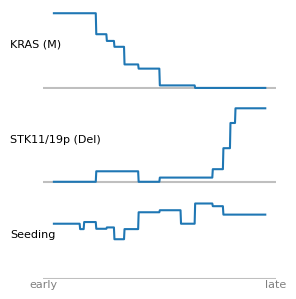

In [13]:
import matplotlib.pyplot as plt

plot_events = [3, 9, seeding_event]

f, a = plt.subplots(nrows=len(plot_events), ncols=1,
                    figsize=(3, 3.5), sharex=True)

for i, e in enumerate(plot_events):

    ax = a[i]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axhline(y=0, color='grey', alpha=0.5)
    ax.plot(range(unit_x), x[e])
    ax.set_ylabel(events[e], rotation=0,
                  fontsize=8, ha="left", labelpad=24,
                  )

    ax.set_ylim(-1, ax.get_ylim()[1])

_ = a[-1].text(x=a[-1].get_xlim()[0], y=a[-1].get_ylim()
           [0], s="early", fontsize=8, color="grey", ha="center", va="top")
_ = a[-1].text(x=a[-1].get_xlim()[1], y=a[-1].get_ylim()
           [0], s="late", fontsize=8, color="grey", ha="center", va="top")